# Quadtree path planning

<a target="_blank" href="https://colab.research.google.com/github/arthurrichards77/smply/blob/master/quadtree.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

Another member of the cell decomposition family, quadtree extends easily to three dimensions, where it becomes octree, or even higher dimensional spaces.  It is an elegant way to partition space when you have little prior information on the typical gap lengths or obstacle sizes, as it adapts representation to suit.  However, it does generate a lot of cells.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random

## Problem definition

Define a workspace in terms of four corners, and introduce some obstacles represented as polygons.  We need outside boundaries as well as the obstacles.  Then plot the world, including a handy utility for plotting closed polygons.

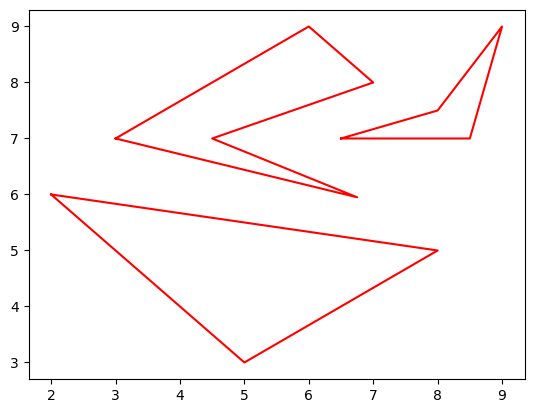

In [2]:
obstacles = [np.array([[2.,6.],[8.,5.],[5.,3.]]),np.array([[6.5,7.],[8.5,7.],[9.,9.],[8.,7.5]])]
obstacles.append(np.array([[3,7],[6.75,5.95],[4.5,7],[7,8],[6,9]]))

def plot_poly(points,fmt='b-',**kwargs):
    plt.plot(np.append(points[:,0],points[0,0]),np.append(points[:,1],points[0,1]),fmt)

for ob in obstacles:
    plot_poly(ob,'r-')
plt.show()

## Roadmap generation

We're going to proceed by generating square cells and checking whether or not they overlap with the obstacles.  This is a surprisingly challenging problem to solve: cells might be entirely inside, entirely outside, or partially overlapping.  Similarly, an obstacle could be entirely inside, outside, or overlapping with the cell.

In the final `is_free` function, we do two checks:

1. If any obstacle corner is inside the cell, return `False`, i.e. the cell is not free from obstacle edges.  Then...
2. If any corner of the cell is not visible from the next corner, because an obstacle gets in the way, return, `False`.  This uses the same visibility testing as used in the [visibility graph example](https://github.com/arthurrichards77/smply/blob/master/visibility.ipynb).

In [3]:
def lines_cross(a,b,c,d):
    M = np.array([[b[0]-a[0],c[0]-d[0]],[b[1]-a[1],c[1]-d[1]]])
    if np.linalg.det(M)==0.:
        return(False)
    v = np.array([[c[0]-a[0]],[c[1]-a[1]]])
    w = np.linalg.solve(M,v)
    if w[0]<=0:
        return(False)
    elif w[0]>=1:
        return(False)
    elif w[1]<=0:
        return(False)
    elif w[1]>=1:
        return(False)
    else:
        return(True)
    
def line_crosses_obst(a,b,obst):
    for ii in range(len(obst)):
        if lines_cross(a,b,obst[ii-1],obst[ii]):
            return(True)
    # extra test in case line is completely inside
    num_crosses = 0
    for ii in range(len(obst)):
        if lines_cross(0.5*(a+b),[max(obst[:,0])+0.01,max(obst[:,1])+0.01],obst[ii-1],obst[ii]):
            num_crosses = num_crosses+1
    if num_crosses%2==1:
        return(True)
    return(False)
            
def is_visible(a,b,obstacles):
    for ob in obstacles:
        if line_crosses_obst(a,b,ob):
            return(False)
    return(True)

def is_free(xlo,ylo,xhi,yhi,obstacles):
    for ob in obstacles:
        for p in ob[:]:
            if p[0]>xlo and p[0]<xhi:
                if p[1]>ylo and p[1]<yhi:
                    return(False)
    if not is_visible(np.array([xlo,ylo]),np.array([xlo,yhi]),obstacles):
        return(False)
    elif not is_visible(np.array([xlo,yhi]),np.array([xhi,yhi]),obstacles):
        return(False)
    elif not is_visible(np.array([xhi,yhi]),np.array([xhi,ylo]),obstacles):
        return(False)
    elif not is_visible(np.array([xhi,ylo]),np.array([xlo,ylo]),obstacles):
        return(False)
    else:
        return(True)

Now run the quadtree algorithm, noting that it's recursive, i.e. it calls itself.  The algorithm itself is pretty simple:

1. Use the outer boundary as the starting current cell.
2. Cut the current cell into four.
3. Test each new cell.  If it is not free, i.e. it contains any part of an obstacle edge, use this algorithm to divide it further.

> Recursion is generally accepted as pretty bad practice in critical code, as it is difficult to prove it won't run forever in an infinite loop.  A better way, certainly in a flight control setting, would be to have a fixed `for` loop that works on a list of active cells at each run. 

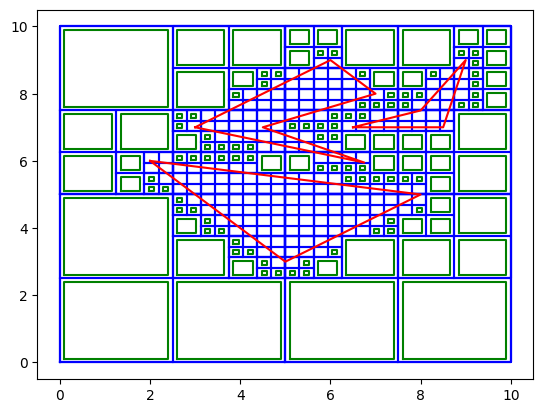

[(0.0, 0.0, 2.5, 2.5), (2.5, 2.5, 3.75, 3.75), (2.5, 3.75, 3.125, 4.375), (2.5, 4.375, 2.8125, 4.6875), (2.5, 4.6875, 2.8125, 5.0), (2.8125, 4.375, 3.125, 4.6875), (3.125, 3.75, 3.4375, 4.0625), (3.125, 4.0625, 3.4375, 4.375), (3.4375, 3.75, 3.75, 4.0625), (3.75, 2.5, 4.375, 3.125), (3.75, 3.125, 4.0625, 3.4375), (3.75, 3.4375, 4.0625, 3.75), (4.0625, 3.125, 4.375, 3.4375), (4.375, 2.5, 4.6875, 2.8125), (4.375, 2.8125, 4.6875, 3.125), (4.6875, 2.5, 5.0, 2.8125), (0.0, 2.5, 2.5, 5.0), (2.5, 0.0, 5.0, 2.5), (5.625, 5.625, 5.9375, 5.9375), (5.9375, 5.625, 6.25, 5.9375), (5.0, 5.625, 5.625, 6.25), (6.25, 6.25, 6.875, 6.875), (6.5625, 7.1875, 6.875, 7.5), (6.25, 7.1875, 6.5625, 7.5), (6.875, 6.25, 7.5, 6.875), (5.625, 6.875, 5.9375, 7.1875), (5.9375, 7.1875, 6.25, 7.5), (5.9375, 6.875, 6.25, 7.1875), (5.0, 6.875, 5.3125, 7.1875), (5.3125, 6.875, 5.625, 7.1875), (5.9375, 6.5625, 6.25, 6.875), (5.625, 6.5625, 5.9375, 6.875), (6.5625, 5.3125, 6.875, 5.625), (6.25, 5.3125, 6.5625, 5.625), (6.87

In [4]:
cells = []
tol = 0.6

def quadtree(xlo,ylo,xhi,yhi,obstacles):
    #print(xlo,ylo,xhi,yhi)
    assert(xhi>xlo)
    assert(yhi>ylo)
    plt.plot([xlo,xlo,xhi,xhi,xlo],[ylo,yhi,yhi,ylo,ylo],'b-')
    if is_free(xlo,ylo,xhi,yhi,obstacles):
        plt.plot([xlo+0.1,xlo+0.1,xhi-0.1,xhi-0.1,xlo+0.1],[ylo+0.1,yhi-0.1,yhi-0.1,ylo+0.1,ylo+0.1],'g-')
        cells.append((xlo,ylo,xhi,yhi))
    elif xhi>xlo+tol:
        quadtree(xlo,ylo,0.5*(xlo+xhi),0.5*(ylo+yhi),obstacles)
        quadtree(0.5*(xlo+xhi),0.5*(ylo+yhi),xhi,yhi,obstacles)
        quadtree(xlo,0.5*(ylo+yhi),0.5*(xlo+xhi),yhi,obstacles)
        quadtree(0.5*(xlo+xhi),ylo,xhi,0.5*(ylo+yhi),obstacles)
    
bl = [0.,0.]
tr = [10.,10.]
quadtree(bl[0],bl[1],tr[0],tr[1],obstacles)

for ob in obstacles:
    plot_poly(ob,'r-')
plt.show()

print(cells)

This next section looks for adjacencies between cells.  It compiles the roadmap, consisting of:
* `nodes` - a list of node locations, given by the midpoints of adjoining obstacle-free cells
* `d` - the distance matrix, capturing the distance between nodes (or `inf` if they can't see eachother)
* `cell_nodes` - a list of node indices attached to each cell

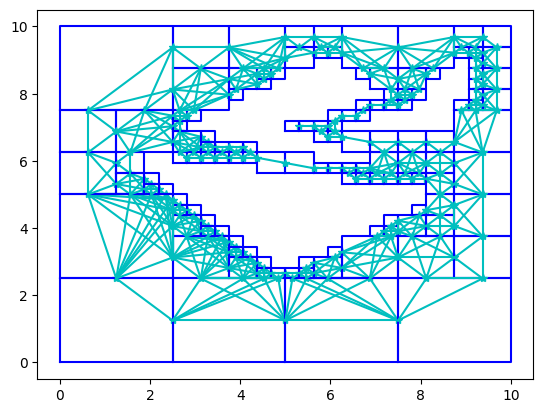

[[       inf 1.76776695        inf ...        inf        inf        inf]
 [1.76776695        inf        inf ...        inf        inf        inf]
 [       inf        inf        inf ...        inf        inf        inf]
 ...
 [       inf        inf        inf ...        inf        inf        inf]
 [       inf        inf        inf ...        inf        inf 1.25      ]
 [       inf        inf        inf ...        inf 1.25              inf]]


In [5]:
num_cells = len(cells)
nodes = []
cell_nodes = [[] for c in cells]

d = np.inf+np.zeros((4*num_cells,4*num_cells))
from numpy.linalg import norm

for ii in range(num_cells):
    (xlo,ylo,xhi,yhi) = cells[ii]
    plt.plot([xlo,xlo,xhi,xhi,xlo],[ylo,yhi,yhi,ylo,ylo],'b-')
    for jj in range(num_cells):
        (xlo2,ylo2,xhi2,yhi2) = cells[jj]
        # look for neighbours to the right
        if xlo2==xhi and ylo2<yhi and yhi2>ylo:
            yloi = max((ylo,ylo2))
            yhii = min((yhi,yhi2))
            new_node = np.array([xhi,0.5*(yloi+yhii)])
            plt.plot(new_node[0],new_node[1],'*c')
            new_node_idx = len(nodes)
            for kk in cell_nodes[ii]:
                plt.plot([nodes[kk][0],new_node[0]],[nodes[kk][1],new_node[1]],'c')
                d[kk,new_node_idx] = norm(nodes[kk]-new_node)
                d[new_node_idx,kk] = d[kk,new_node_idx]
            for kk in cell_nodes[jj]:
                plt.plot([nodes[kk][0],new_node[0]],[nodes[kk][1],new_node[1]],'c')
                d[kk,new_node_idx] = norm(nodes[kk]-new_node)
                d[new_node_idx,kk] = d[kk,new_node_idx]
            nodes.append(new_node)
            cell_nodes[ii].append(new_node_idx)
            cell_nodes[jj].append(new_node_idx)
        # and look for neighbours to the top
        if ylo2==yhi and xlo2<xhi and xhi2>xlo:
            xloi = max((xlo,xlo2))
            xhii = min((xhi,xhi2))
            new_node = np.array([0.5*(xloi+xhii),yhi])
            plt.plot(new_node[0],new_node[1],'*c')
            new_node_idx = len(nodes)
            for kk in cell_nodes[ii]:
                plt.plot([nodes[kk][0],new_node[0]],[nodes[kk][1],new_node[1]],'c')
                d[kk,new_node_idx] = norm(nodes[kk]-new_node)
                d[new_node_idx,kk] = d[kk,new_node_idx]
            for kk in cell_nodes[jj]:
                plt.plot([nodes[kk][0],new_node[0]],[nodes[kk][1],new_node[1]],'c')
                d[kk,new_node_idx] = norm(nodes[kk]-new_node)
                d[new_node_idx,kk] = d[kk,new_node_idx]
            nodes.append(new_node)
            cell_nodes[ii].append(new_node_idx)
            cell_nodes[jj].append(new_node_idx)

plt.show()

d = d[0:len(nodes),0:len(nodes)]
print(d)

## Adding the start and goal

Time to attach a start and a goal node.  First, identify which cell each is in.  

We'll get an error if start or end aren't in any cell, i.e. inside the obstacle.  To minimize this, the code has a futher ten attempts at finding a random start and goal point that are obstacle free.

90
129


/var/folders/5v/8ygvppms6tj1217vhdh1b8f40000gn/T/ipykernel_2554/1381189054.py:1: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  start_point = np.array([random.randrange(bl[0],tr[0]), random.randrange(bl[1],tr[1])])
/var/folders/5v/8ygvppms6tj1217vhdh1b8f40000gn/T/ipykernel_2554/1381189054.py:12: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  goal_point = np.array([random.randrange(bl[0],tr[0]), random.randrange(bl[1],tr[1])])


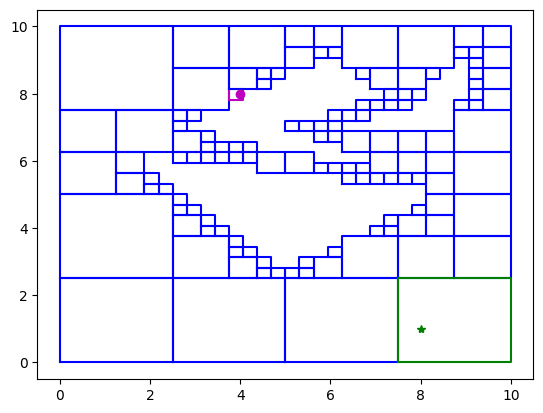

In [6]:
start_point = np.array([random.randrange(bl[0],tr[0]), random.randrange(bl[1],tr[1])])
start_list = [ii for ii in range(num_cells) if cells[ii][0]<=start_point[0] and cells[ii][1]<=start_point[1] and cells[ii][2]>=start_point[0] and cells[ii][3]>=start_point[1]]
for rr in range(10):
  if start_list:
    break
  else:
    start_point = np.array([random.randrange(bl[0],tr[0]), random.randrange(bl[1],tr[1])])
    start_list = [ii for ii in range(num_cells) if cells[ii][0]<=start_point[0] and cells[ii][1]<=start_point[1] and cells[ii][2]>=start_point[0] and cells[ii][3]>=start_point[1]]
start_cell = start_list[0]
print(start_cell)

goal_point = np.array([random.randrange(bl[0],tr[0]), random.randrange(bl[1],tr[1])])
goal_list = [ii for ii in range(num_cells) if cells[ii][0]<=goal_point[0] and cells[ii][1]<=goal_point[1] and cells[ii][2]>=goal_point[0] and cells[ii][3]>=goal_point[1]]
for rr in range(10):
  if goal_list:
    break
  else:
    goal_point = np.array([random.randrange(bl[0],tr[0]), random.randrange(bl[1],tr[1])])
    goal_list = [ii for ii in range(num_cells) if cells[ii][0]<=goal_point[0] and cells[ii][1]<=goal_point[1] and cells[ii][2]>=goal_point[0] and cells[ii][3]>=goal_point[1]]
goal_cell = goal_list[0]
print(goal_cell)

for ii in range(num_cells):
    (xlo,ylo,xhi,yhi) = cells[ii]
    if ii==start_cell:
        plt.plot([xlo,xlo,xhi,xhi,xlo],[ylo,yhi,yhi,ylo,ylo],'m-')
    elif ii==goal_cell:
        plt.plot([xlo,xlo,xhi,xhi,xlo],[ylo,yhi,yhi,ylo,ylo],'g-')
    else:
        plt.plot([xlo,xlo,xhi,xhi,xlo],[ylo,yhi,yhi,ylo,ylo],'b-')
plt.plot(start_point[0],start_point[1],'mo')
plt.plot(goal_point[0],goal_point[1],'g*')
plt.show()

Augment the nodes list and distance matrix to include the start and goal.

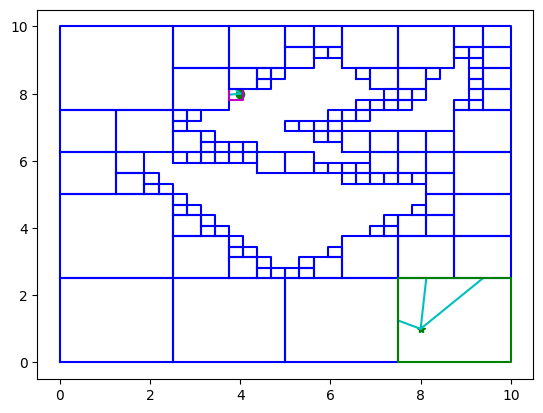

In [7]:
def append_dist_matrix(d,n=1):
    (r,c)=d.shape
    d2 = np.vstack((d,np.inf+np.zeros((n,c))))
    d3 = np.hstack((d2,np.inf+np.zeros((r+n,n))))
    return(d3)

nx_points_aug = nodes[:]
d_aug = append_dist_matrix(d,n=2)

start_idx = len(nx_points_aug)
nx_points_aug.append(start_point)
plt.plot(start_point[0],start_point[1],'go')
for nx in cell_nodes[start_cell]:
    plt.plot([nx_points_aug[start_idx][0],nx_points_aug[nx][0]],[nx_points_aug[start_idx][1],nx_points_aug[nx][1]],'c-')
    d_aug[start_idx,nx]=norm(nx_points_aug[start_idx]-nx_points_aug[nx])
    d_aug[nx,start_idx]=d_aug[start_idx,nx]

goal_idx = len(nx_points_aug)
nx_points_aug.append(goal_point)
plt.plot(goal_point[0],goal_point[1],'g*')
for nx in cell_nodes[goal_cell]:
    plt.plot([nx_points_aug[goal_idx][0],nx_points_aug[nx][0]],[nx_points_aug[goal_idx][1],nx_points_aug[nx][1]],'c-')
    d_aug[goal_idx,nx]=norm(nx_points_aug[goal_idx]-nx_points_aug[nx])
    d_aug[nx,goal_idx]=d_aug[goal_idx,nx]

for ii in range(num_cells):
    (xlo,ylo,xhi,yhi) = cells[ii]
    if ii==start_cell:
        plt.plot([xlo,xlo,xhi,xhi,xlo],[ylo,yhi,yhi,ylo,ylo],'m-')
    elif ii==goal_cell:
        plt.plot([xlo,xlo,xhi,xhi,xlo],[ylo,yhi,yhi,ylo,ylo],'g-')
    else:
        plt.plot([xlo,xlo,xhi,xhi,xlo],[ylo,yhi,yhi,ylo,ylo],'b-')
plt.show()

##  Find the path with graph search

Now run the graph search algorithm.  Notice this is identical to every other roadmap method.

In [8]:
from scipy.sparse.csgraph import shortest_path
distance,predecessors = shortest_path(d_aug, return_predecessors=True)
print(distance)
print(predecessors)

[[ 0.          1.76776695  2.09631373 ...  8.64683749  6.81575145
   7.32678395]
 [ 1.76776695  0.          2.68601299 ...  7.25346955  8.58351841
   5.55901699]
 [ 2.09631373  2.68601299  0.         ...  7.20926459  5.94573277
   5.95391322]
 ...
 [ 8.64683749  7.25346955  7.20926459 ...  0.         11.18105405
   2.03485257]
 [ 6.81575145  8.58351841  5.94573277 ... 11.18105405  0.
  11.74689504]
 [ 7.32678395  5.55901699  5.95391322 ...  2.03485257 11.74689504
   0.        ]]
[[-9999     0    25 ...   215   145   188]
 [    1 -9999    33 ...   188   145   188]
 [   25    33 -9999 ...   215   145   188]
 ...
 [   25    37     6 ... -9999   145   216]
 [   30     0    26 ...   200 -9999   188]
 [    1    37     6 ...   218   145 -9999]]


Finally, reconstruct the path.

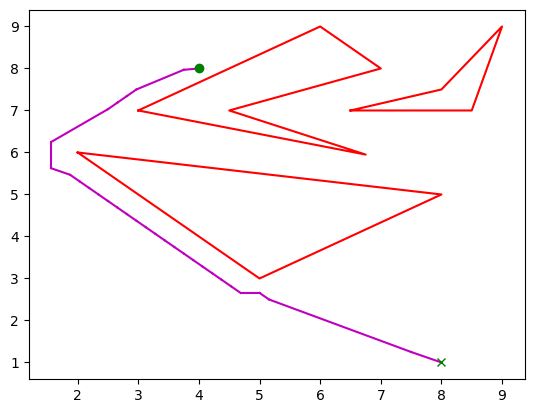

In [9]:
curr_node = start_idx
for kk in range(len(nx_points_aug)):
    next_node = predecessors[goal_idx,curr_node]
    plt.plot([nx_points_aug[curr_node][0],nx_points_aug[next_node][0]],[nx_points_aug[curr_node][1],nx_points_aug[next_node][1]],'m-')
    curr_node=next_node
    if curr_node==goal_idx:
        break
        
for ob in obstacles:
    plot_poly(ob,'r-')
plt.plot(start_point[0],start_point[1],'go',goal_point[0],goal_point[1],'gx')
plt.show()